<a href="https://colab.research.google.com/github/SambamD/Machine-Learning/blob/main/Devoir_Mod%C3%A9lisation_Stochastique_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Devoir Modélisation Stochastique


In [ ]:
!pip install fitter

In [ ]:
!unzip data.zip

Archive:  data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Nous allons importer les librairies dont nous aurons besoin pour le projet.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
from fitter import Fitter
from utils import *

Grâce à cette fonction utilitaire, nous allons pouvoir afficher les appels par jours, par mois, par heure, et par jour de la semaine.

In [ ]:
def plot_number_of_call(data, column:str="day", day_value=None):
    plt.plot(month[[column]].value_counts(sort=False).values)
    plt.xlabel(column.capitalize())
    plt.ylabel("Nombre d'appels")
    plt.suptitle(f"Number of call per {column} for {month_name}")

# 0. Prétraitement et visualisation

Dans notre exemple nous allons utiliser un seul mois. Pour cette étude prenons par exemple le mois de janvier.

In [ ]:
month_name = "January"
root_dir = "data/"

In [ ]:
month = pd.read_csv(f"{root_dir}{month_name}1999.txt", delim_whitespace=True) 

In [ ]:
# columns = [
#     'call_id',
#     'priority', 
#     'date',
#     'type', 
#     'vru_entry',
#     'q_time',
#     'outcome',
#     'ser_time', 
#     'server' 
# ]
# month = month[columns]

Pour des raisons de convenance, nous allons créer de nouvelles colonnes pour le jour de la semaine le jour du mois est l'heure d'entrée dans la file de chaque client

In [ ]:
month['month'] = month['date'].apply(lambda date_int: int2Date(date_int).month)
month['weekday'] = month['date'].apply(lambda date_int: int2Date(date_int).weekday())
month['day'] = month['date'].apply(lambda date_int: int2Date(date_int).day)
month['entry_hour'] = month['vru_entry'].apply(lambda time_str: parse_times(time_str).hour)

Supprimons les colonnes dont nous n'aurons pas besoin dans l'étude.

In [ ]:
month.drop(columns=["vru+line", "customer_id"], inplace=True)
month.head()

,call_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,month,weekday,day,entry_hour
0,33116,2,PS,990101,0:00:31,0:00:36,5,0:00:36,0:03:09,153,HANG,0:00:00,0:00:00,0,NO_SERVER,1,4,1,0
1,33117,0,PS,990101,0:34:12,0:34:23,11,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,1,4,1,0
2,33118,2,PS,990101,6:55:20,6:55:26,6,6:55:26,6:55:43,17,AGENT,6:55:43,6:56:37,54,MICHAL,1,4,1,6
3,33119,0,PS,990101,7:41:16,7:41:26,10,0:00:00,0:00:00,0,AGENT,7:41:25,7:44:53,208,BASCH,1,4,1,7
4,33120,0,PS,990101,8:03:14,8:03:24,10,0:00:00,0:00:00,0,AGENT,8:03:23,8:05:10,107,MICHAL,1,4,1,8


Sachant que les appels "PHANTOM" n'ont aucune valeur ajoutée dans les données, nous allons les supprimer pour faciliter l'analyse. Ceci contribuera à l'amélioration des performances des modèles de prédiction des distributions.

In [ ]:
month = month[month['outcome'] != "PHANTOM"]

Dans cette courbe, nous affichons le nombre d'appels par jour de la semaine pour le mois de janvier. On remarque la présence de pics pour principalement les lundi et une diminution de pendant le samedi. Il y a aussi une forte hausse du nombre d'appel durant les  les dimanches.

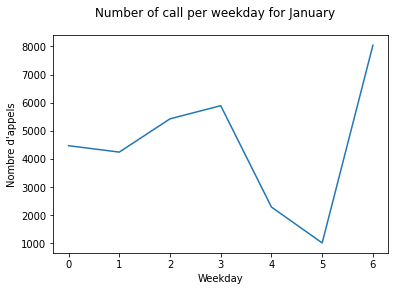

In [ ]:
plot_number_of_call(month, "weekday")

Nous remarquons une grande différence des tendances des appels en début de mois comparée aux appels en fin de mois.En début de mois, entre le 1er et le 5e jour il y a une augmentation radicale des appels et nous remarquons des diminutions fortes pratiquement tous les 14 jours ce qui montre que ce sont des pics vers le bas induits par la présence des weekends.

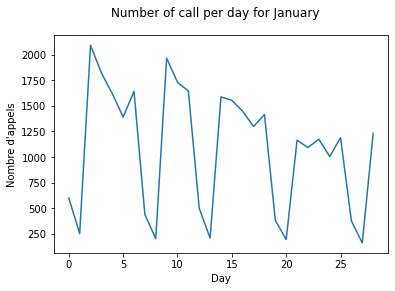

In [ ]:
plot_number_of_call(month, "day")

Il peut être aussi très intéressant de regarder la tendance des appels par rapport à l'heure d'arrivée (c'est-à-dire l'heure d'entrer dans le VRU). On remarque dès le départ que malgré qu'il n'y ait pas d'appel permis avant 8h et après 20h, il y a quand même des appels mais à un nombre très réduit. Le pic d'appels se passe à partir du matin entre 8h et 10h principalement à 9h et à 17h ce sont les principales où nous remarquons des d'appel pour le mois de janvier.


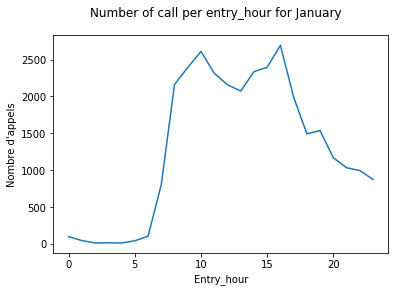

In [ ]:
plot_number_of_call(month, "entry_hour")

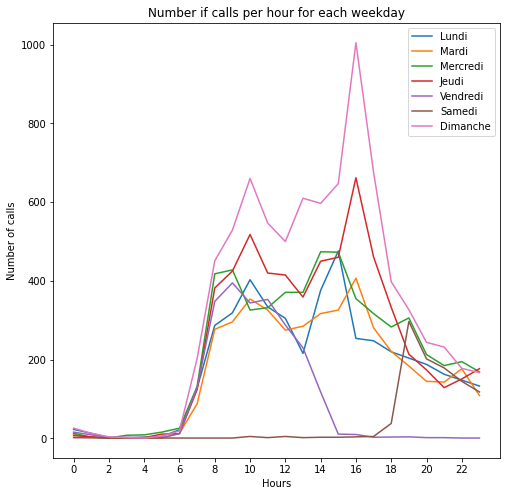

In [ ]:
plt.figure(figsize=[8, 8])
for day_of_the_week in range(7):
    days = month[month["weekday"] == day_of_the_week]
    number_of_days = days.shape[0]
    data = days[['entry_hour', 'call_id']].groupby('entry_hour', as_index=False).count()
    sns.lineplot(x="entry_hour", y="call_id", data=data)
    plt.xticks(range(0, 24, 2))
    plt.legend(["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"])
    plt.title("Number if calls per hour for each weekday")
    plt.xlabel("Hours")
    plt.ylabel("Number of calls")
plt.show()

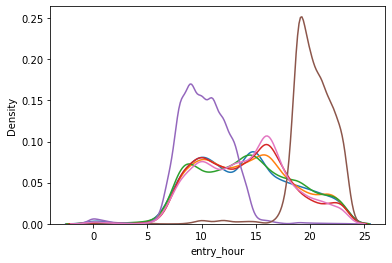

In [ ]:
for weekday in range(7):
    sns.kdeplot(month['entry_hour'][month['weekday']==weekday],)

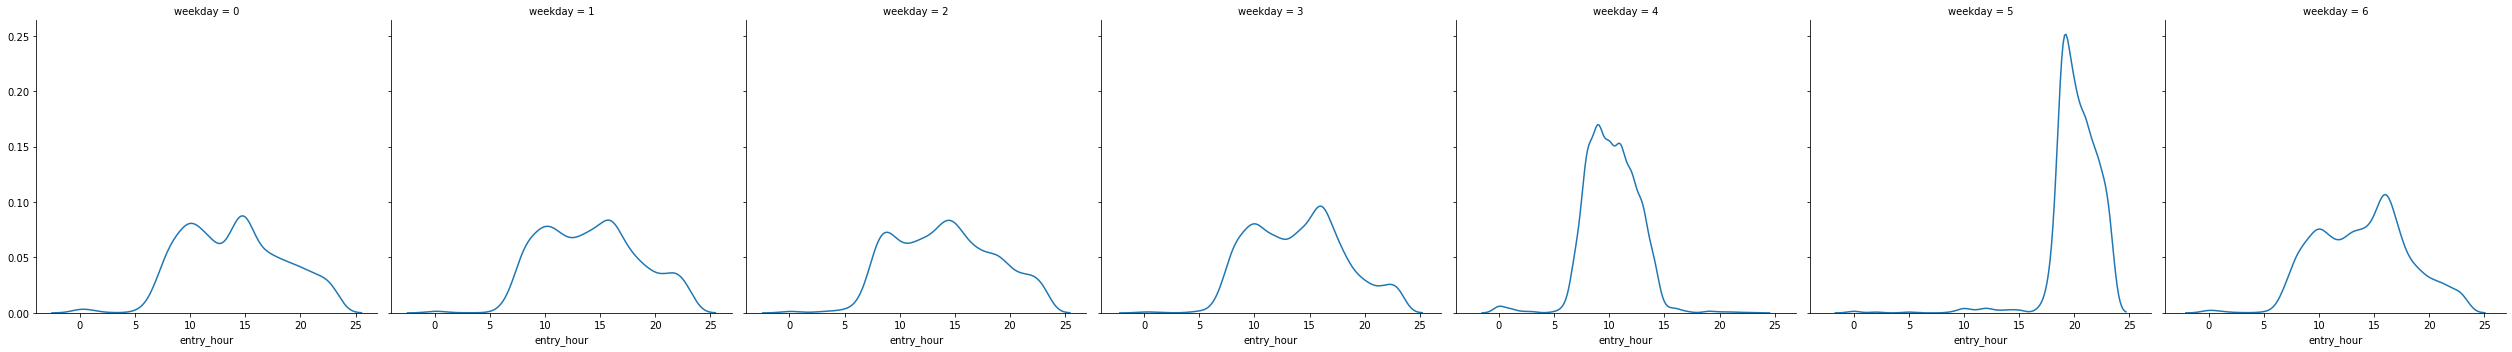

In [ ]:
g = sns.FacetGrid(month, col="weekday", height=5)
g.map(sns.kdeplot, "entry_hour")

In [ ]:
def plot_number_of_call_for_weekday(weekday, month, index=None):
    days_of_month = month[['entry_hour', 'call_id', 'day']][month['weekday'] == weekday]
    days = days_of_month.day.unique()
    for day in days:
        data = days_of_month[days_of_month['day'] == day].groupby('entry_hour').count()
        sns.lineplot(x="entry_hour", y="call_id", data=data,)
        plt.xticks(range(0, 24, 2))
        plt.title(f"Number of calls of day {weekday}")
        plt.xlabel("Hours")
        plt.ylabel("Number of calls")

On remarque clairement une différence entre le dimanche et les autres jours de la semaine. Nous remarquons aussi que le lundi se décale un peu par rapport aux autres jours de la semaine. Mais les pics arrivent toujours entre 14h et 18h et le matin entre 8h et 10h. On peut dire que globalement les courbes des jours de la semaine, bien qu'ayant de légères différences au niveau des valeurs des maxima et des minima, ont une tendance régulière et quasi similaire: une diminution des appelsdurant les heures creuses (entre 12h et 15h) et deux pics durant les heures de pointe (les courbes ont globalement la même forme). C'est-à-dire que les courbes ont globalement la même tendance et que certains jours peuvent être regroupés. Toutefois, dans notre étude, pour plus de précisions, nous allons séparer chaque distribution de chaque jour

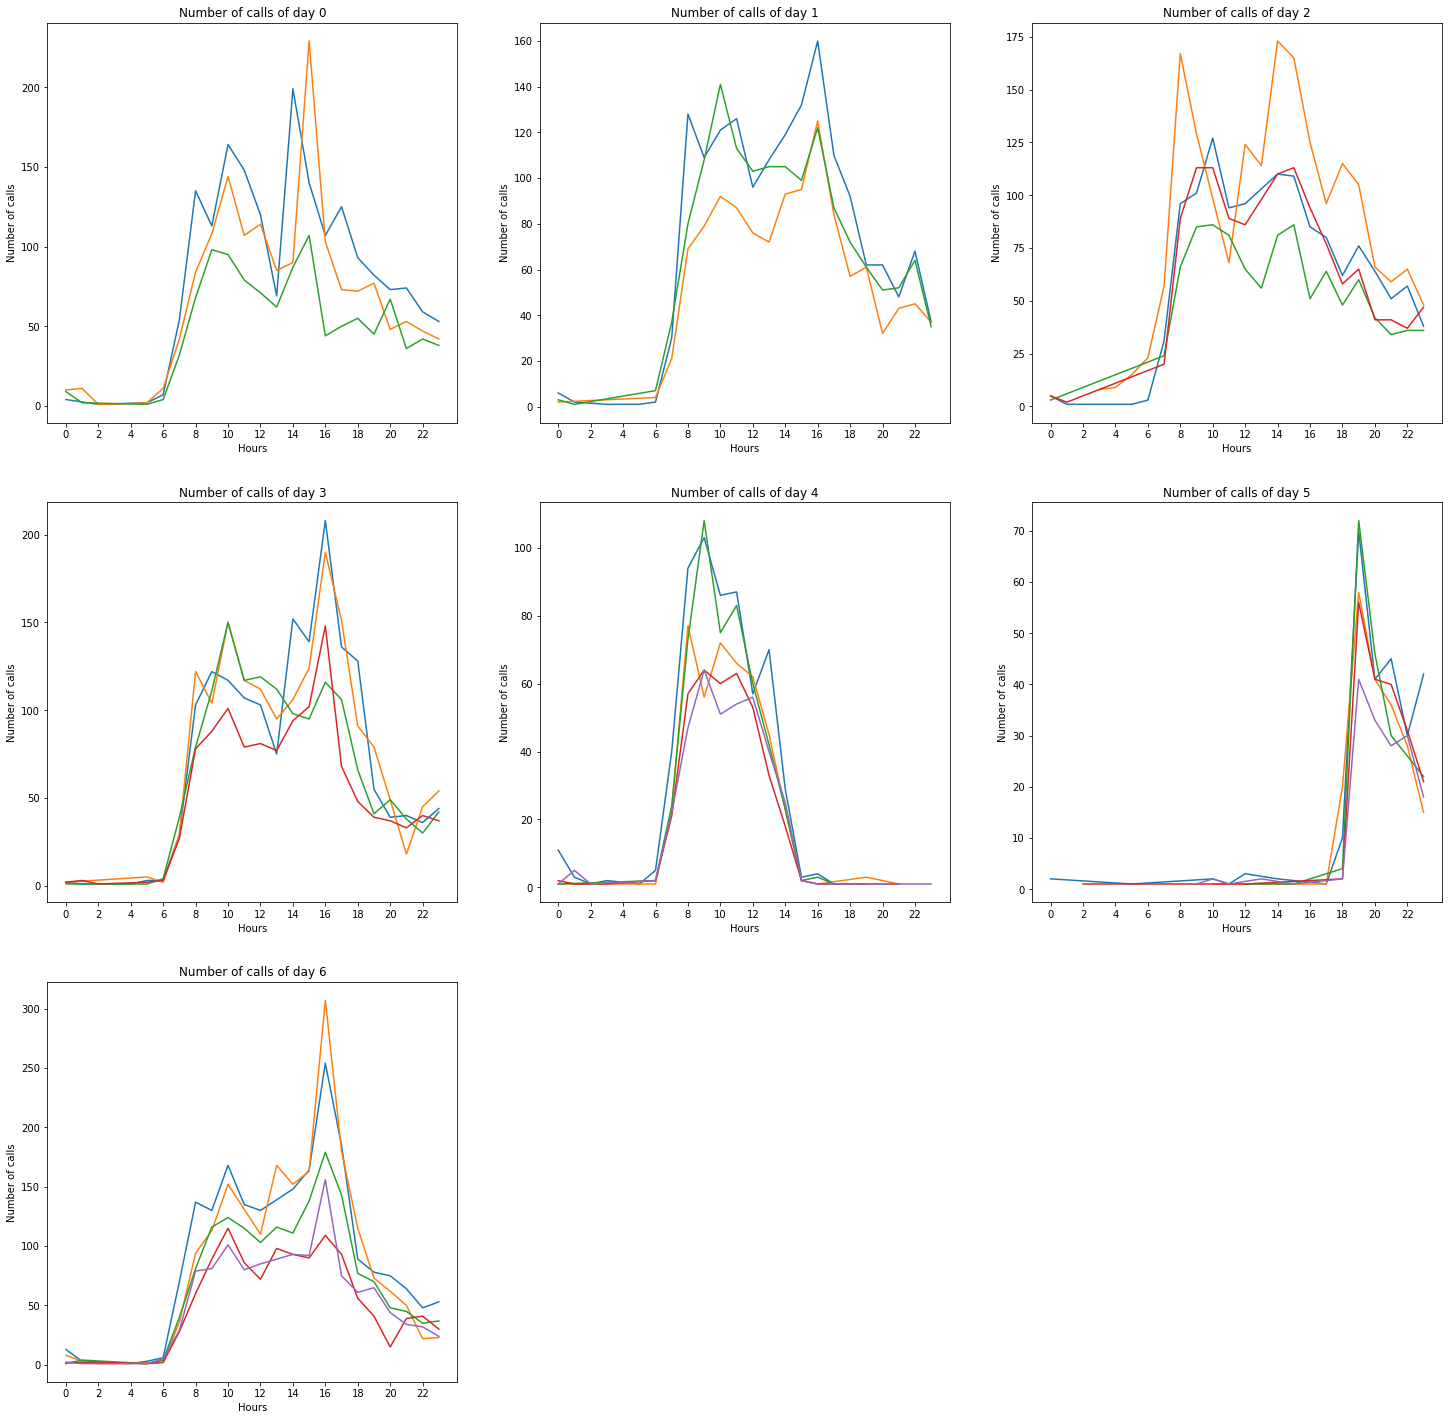

In [ ]:
plt.figure(figsize=[25, 25])
for weekday in range(7):
    plt.subplot(3, 3, weekday+1)
    plot_number_of_call_for_weekday(weekday, month, weekday)

# 1. Identifier les différentes type services (i.e les différentes types de clients) et modéliser la loi des arrivées pour chaque type service

In [ ]:
service_types = month['type'].unique()
service_types

array(['PS', 'NW', 'PE', 'NE', 'TT', 'IN', 'AA'], dtype=object)

Là, nous avons identifié six(6) types de sevice : 


*   PS
*   NW
*   PE
*   NE
*   TT
*   IN
*   AA

In [ ]:
month.tail()

,call_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,month,weekday,day,entry_hour
31594,5460,0,IN,990131,14:05:51,14:06:00,9,14:06:00,14:11:08,308,AGENT,14:09:59,14:13:08,189,TOVA,1,6,31,14
31595,5461,0,IN,990131,16:55:02,16:55:14,12,0:00:00,0:00:00,0,AGENT,16:55:13,17:02:04,411,YIFAT,1,6,31,16
31596,5462,0,IN,990131,21:59:43,22:00:01,18,0:00:00,0:00:00,0,AGENT,22:00:00,22:03:11,191,MICHAL,1,6,31,21
31597,5463,0,IN,990131,23:22:59,23:23:09,10,23:23:09,23:24:16,67,AGENT,23:24:15,23:26:04,109,BENSION,1,6,31,23
31598,5464,0,IN,990131,23:26:18,23:26:27,9,23:26:27,23:26:44,17,AGENT,23:26:43,23:27:45,62,BENSION,1,6,31,23


Pour la loi des arrivées,  on travaille avec le service de type PS vu que c'est la même logique pour tous les services.
On sélectionne le premier jour du mois et la colonne vru_entry.

In [ ]:
day = month[month["day"]==1]

In [ ]:
day

,call_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,month,weekday,day,entry_hour
0,33116,2,PS,990101,0:00:31,0:00:36,5,0:00:36,0:03:09,153,HANG,0:00:00,0:00:00,0,NO_SERVER,1,4,1,0
1,33117,0,PS,990101,0:34:12,0:34:23,11,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,1,4,1,0
2,33118,2,PS,990101,6:55:20,6:55:26,6,6:55:26,6:55:43,17,AGENT,6:55:43,6:56:37,54,MICHAL,1,4,1,6
3,33119,0,PS,990101,7:41:16,7:41:26,10,0:00:00,0:00:00,0,AGENT,7:41:25,7:44:53,208,BASCH,1,4,1,7
4,33120,0,PS,990101,8:03:14,8:03:24,10,0:00:00,0:00:00,0,AGENT,8:03:23,8:05:10,107,MICHAL,1,4,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31457,5323,0,IN,990101,9:19:14,9:19:24,10,9:19:24,9:22:34,190,HANG,0:00:00,0:00:00,0,NO_SERVER,1,4,1,9
31458,5324,0,IN,990101,9:58:06,9:58:37,31,0:00:00,0:00:00,0,AGENT,9:58:36,9:59:59,83,MICHAL,1,4,1,9
31459,5325,0,IN,990101,10:14:53,10:15:02,9,10:15:02,10:16:27,85,HANG,0:00:00,0:00:00,0,NO_SERVER,1,4,1,10
31460,5326,0,IN,990101,10:46:12,10:46:22,10,10:46:22,10:46:45,23,AGENT,10:46:45,10:47:23,38,MICHAL,1,4,1,10


Vu que les données sont des chaines de caractères, il est nécessaire de les transformer en format date puis en secondes  pour pouvoir afficher leur distribution. Pour ce faire, nous utilisons la fonction dateToSecond qu'on avait écrite précedemment.

In [ ]:
arrivals = dateToSecond(parse_times(day[day['type']=='PS'], column_name='vru_entry'))

In [ ]:
arrivals.head()

0       31
1     2052
2    24920
3    27676
4    28994
Name: vru_entry, dtype: int64

La fonction get_inter_arrivals permet de calculer les inter-arrivées à partir de la liste des arrivées. 

In [ ]:
inter_arrivals = get_inter_arrivals(arrivals.sort_values())

Maintenant, sans aucune connaissance de la distribution ou de son paramètre, quelle est la distribution qui correspond le mieux aux données? Scipy a 80 distributions et la classe Fitter les analysera toutes, appellera la fonction fit pour nous, ignorant celles qui échouent ou s'exécutent pour toujours et nous donnera enfin un résumé des meilleures distributions dans le sens de la somme des erreurs carrées.

Lorsque l'on estime un modèle statistique, il est possible d'augmenter la vraisemblance du modèle en ajoutant un paramètre. Le critère d'information d'Akaike (aic), tout comme le critère d'information bayésien (bic), permet de pénaliser les modèles en fonction du nombre de paramètres afin de satisfaire le critère de parcimonie. On choisit alors le modèle avec le critère d'information d'Akaike le plus faible. 

En résumé plus le aic est faible plus le modèle est bon.
Nous utiliserons donc comme critère de performance: 

1.   La somme des erreurs quadratiques
2.   Le AIC (critère d'information d'Akaike)
3.   Le BIC (critère d'information bayésien)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Summary...


,sumsquare_error,aic,bic,kl_div
burr12,0.000143,3574.584423,-6978.801982,inf
geninvgauss,0.000152,3760.725936,-6952.623011,inf
invgauss,0.000227,3532.270267,-6770.771577,inf
gilbrat,0.000234,3540.970300,-6761.817092,inf
wald,0.000245,3691.325373,-6741.472005,inf


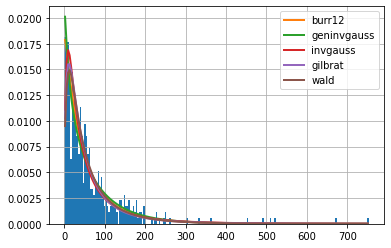

In [ ]:
inter_arrivals_distributions = [
     'wald', 'burr12', 'lognorm', 
     'gilbrat', 'invgauss', 'cauchy', 
     'betaprime', 'f', 'invgamma', 
     'geninvgauss'
]

fitter_arrivals = Fitter(data=inter_arrivals, distributions=inter_arrivals_distributions, bins=200, xmax=1000)
fitter_arrivals.fit(progress=True)

print(f"Summary...")
fitter_arrivals.summary(Nbest=5)

La distribution de type Burr 12 est une famille de distributions à trois paramètres sur R+.
Elle est utilisé dans divers domaines tels que la finance, l'hydrologie et la fiabilité pour modéliser divers types de données. Des exemples de données modélisées par la distribution de Burr sont le revenu des ménages, les prix des récoltes, le risque d'assurance, le temps de trajet, les niveaux d'inondations et les données de défaillance.

La distribution de Burr à trois paramètres est définie par son paramètre d'échelle α et les paramètres de forme c et k.

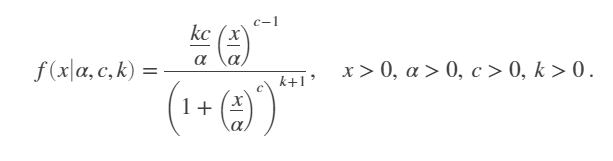

In [ ]:
fitter_arrivals.get_best()

{'burr12': (519.8621945703965,
  0.009542883624444984,
  -258.11209266033876,
  258.30293573977804)}

# 2. Modéliser la loi des temps de patience des clients 

Pour la loi des temps de patience,  on sélectionne les clients qui n'ont pas été servis c'est-à-dire dont la colonne outcome est égale à HANG. Le reste, on ne peut pas déterminer leur temps de patience car il nous est impossible de dire combien de temps ils auraient attendu si il n'avaient pas eu d'agent à leur service.

In [ ]:
waiters = day[day['outcome']=='HANG']

In [ ]:
patience_time = waiters['q_time'].values

In [ ]:
patience_time

array([153,   0, 112,   0,   0,   0,  51,  11,   0,   0,   0,  46,   0,
         0,   0,   0,   1,   0,   0,   0,   5,   0,   0,   0, 140,   0,
         0,   0,  71,   0,   0,   0,  39,   0,   0,   0,   0,   0,   0,
        12,   9,   0,  98,   0,  44,   0,   0,   0,  10,   0,   0,  39,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        13,   0,   0,   0,   0,  75,   0,   0,   0,  15,  33,   0,   0,
         0,  52,  48,   0,   0,  33,  18,  25,   0, 133,   0,   0,   0,
       190,  85])

In [ ]:
patience_distributions = ['pareto', 'exponweib', 'betaprime', 'fisk', 'f']

In [ ]:
fitter_patience = Fitter(data=patience_time, distributions=patience_distributions, bins=200, xmax=100)
fitter_patience.fit(progress=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Summary...


,sumsquare_error,aic,bic,kl_div
betaprime,0.439728,4555.560963,-448.397093,inf
f,1.190814,2564.838091,-360.728234,inf
exponweib,1.235240,2744.244272,-357.504962,inf
fisk,1.870260,2780.092605,-325.478819,inf
pareto,2.286840,33058.042218,-307.782591,inf


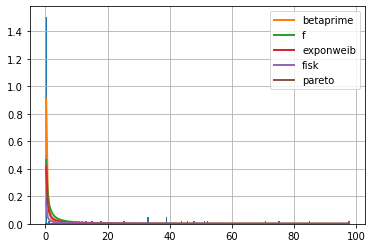

In [ ]:
print(f"Summary...")
fitter_patience.summary(Nbest=5)

En théorie des probabilités et en statistique, la distribution bêta prime (également appelée distribution bêta inversée ou distribution bêta du second type) est une distribution de probabilité absolument continue définie pour x> 0 avec deux paramètres α et β, ayant la fonction de densité de probabilité:

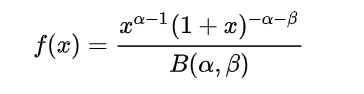

In [ ]:
fitter_patience.get_best()

{'betaprime': (0.5332625945681216,
  2.1678949944089085,
  -3.549319627436445e-29,
  1.1570850227455467)}

# 3. Modéliser la loi des durées de service des agents pour chaque type de service

Là, on choisit les clients qui ont été servis par un agent c'est-à-dire ceux dont les temps de service sont non nuls.

In [ ]:
service_time = day[(day['outcome']=='AGENT') & (day['ser_time']!=0)]['ser_time'].values

In [ ]:
service_time[:5]

array([ 54, 208, 107, 275, 102])

In [ ]:
fitter_service = Fitter(data=service_time, bins=200)
fitter_service.fit(progress=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(f"Summary...")
fitter_service.summary(Nbest=5)

In [ ]:
fitter_service.get_best()

La distribution de Cauchy est souvent utilisée en statistique comme exemple canonique d'une distribution «pathologique» puisque tant sa valeur attendue que sa variance ne sont pas définies. La distribution de Cauchy n'a pas de moments finis d'ordre supérieur ou égal à un; seuls les moments absolus fractionnaires existent. La distribution de Cauchy n'a pas de fonction génératrice de moment.

# 4. Ecrire un programme java pour simuler le centre d’appels d’appels (générer les arrivées, placer les clients à la bonne position dans la file, router les clients vers les agents en utilisant la politique de routage d´efini par manager, gérer le staffing des agents avant le début de la simulation)


Voir code Java

# 5. Comparer les mesures de performances votre simulateur avec les mesures de performances obtenues avec les données (par exemple le temps d’attente moyen des clients, le niveau de service, le taux d’occupation des agents)